## A Quick Guide to fine tuning transfer learning 
To begin, we will investigate the different layers of a keras model. Let's use Xception

In [1]:
import pandas as pd
import numpy as np
from keras.applications.xception import preprocess_input
from keras.applications import Xception
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from keras.optimizers import SGD, RMSprop


Using TensorFlow backend.


In [30]:
input_size = (244,244,3)
model = Xception(weights='imagenet',
                          include_top=True,
                          input_shape=input_size)

Here is a function that will show us all of the layers of a model and whether or not they are trainable, with an optional argument to show what 
layer we want to start at

In [3]:
def print_model_properties(model, indices = 0):
     for i, layer in enumerate(model.layers[indices:]):
        print(f"Layer {i+indices} | Name: {layer.name} | Trainable: {layer.trainable}")


In [33]:
print_model_properties(model)

Layer 0 | Name: input_3 | Trainable: False
Layer 1 | Name: block1_conv1 | Trainable: True
Layer 2 | Name: block1_conv1_bn | Trainable: True
Layer 3 | Name: block1_conv1_act | Trainable: True
Layer 4 | Name: block1_conv2 | Trainable: True
Layer 5 | Name: block1_conv2_bn | Trainable: True
Layer 6 | Name: block1_conv2_act | Trainable: True
Layer 7 | Name: block2_sepconv1 | Trainable: True
Layer 8 | Name: block2_sepconv1_bn | Trainable: True
Layer 9 | Name: block2_sepconv2_act | Trainable: True
Layer 10 | Name: block2_sepconv2 | Trainable: True
Layer 11 | Name: block2_sepconv2_bn | Trainable: True
Layer 12 | Name: conv2d_9 | Trainable: True
Layer 13 | Name: block2_pool | Trainable: True
Layer 14 | Name: batch_normalization_9 | Trainable: True
Layer 15 | Name: add_25 | Trainable: True
Layer 16 | Name: block3_sepconv1_act | Trainable: True
Layer 17 | Name: block3_sepconv1 | Trainable: True
Layer 18 | Name: block3_sepconv1_bn | Trainable: True
Layer 19 | Name: block3_sepconv2_act | Trainable:

Now let's predict load and predict an image to see what we're working with

In [34]:
def process_img(filename):
    """
    Loads image from filename, preprocesses it and expands the dimensions because the model predict function expects a batch of images, not one image
    """
    original = load_img(filename, target_size = (244,244))
    numpy_image = preprocess_input( img_to_array(original))
    image_batch = np.expand_dims(numpy_image, axis =0)

    return image_batch


In [35]:
process_img('../data/holdout_more/churros/1067707.jpg').shape

(1, 244, 244, 3)

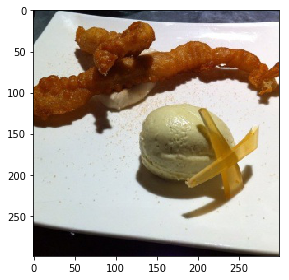

(1, 1000)

In [9]:
im =  process_img('../data/holdout_more/churros/1067707.jpg')
preds =  model.predict(im)
from skimage import io
import matplotlib.pyplot as plt
io.imshow('../data/holdout_more/churros/1353487.jpg')
plt.show()
#Image net has 1000 different classes
preds.shape

In [10]:
preds = preds.flatten()
print("Sum of output:", preds.sum().round(4))
print("Top 5 Probabilities", np.sort(preds)[::-1][:5])
top_5_indices = preds.argsort()[::-1][:5]
print("Top 5 Indices", top_5_indices)


Sum of output: 1.0
Top 5 Probabilities [0.21204048 0.17643066 0.15487862 0.14528216 0.04979189]
Top 5 Indices [967 923 960 925 121]


In [11]:
class_names  = pd.read_json('imagenet_class_index.json', orient='index')
class_names.iloc[top_5_indices]

,0,1
967,n07920052,espresso
923,n07579787,plate
960,n07836838,chocolate_sauce
925,n07584110,consomme
121,n01981276,king_crab


## Transfer learning
### 1. Remove head 

In [13]:
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras.models import Model

def create_transfer_model(input_size, n_categories, weights = 'imagenet'):
        
        base_model = Xception(weights=weights,
                          include_top=False,
                          input_shape=input_size)
        
        model = base_model.output
        model = GlobalAveragePooling2D()(model)
        predictions = Dense(n_categories, activation='softmax')(model)
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model




In [14]:
model = create_transfer_model((299,299,3),10)

In [15]:
print_model_properties(model)

Layer 0 | Name: input_2 | Trainable: False
Layer 1 | Name: block1_conv1 | Trainable: True
Layer 2 | Name: block1_conv1_bn | Trainable: True
Layer 3 | Name: block1_conv1_act | Trainable: True
Layer 4 | Name: block1_conv2 | Trainable: True
Layer 5 | Name: block1_conv2_bn | Trainable: True
Layer 6 | Name: block1_conv2_act | Trainable: True
Layer 7 | Name: block2_sepconv1 | Trainable: True
Layer 8 | Name: block2_sepconv1_bn | Trainable: True
Layer 9 | Name: block2_sepconv2_act | Trainable: True
Layer 10 | Name: block2_sepconv2 | Trainable: True
Layer 11 | Name: block2_sepconv2_bn | Trainable: True
Layer 12 | Name: conv2d_5 | Trainable: True
Layer 13 | Name: block2_pool | Trainable: True
Layer 14 | Name: batch_normalization_5 | Trainable: True
Layer 15 | Name: add_13 | Trainable: True
Layer 16 | Name: block3_sepconv1_act | Trainable: True
Layer 17 | Name: block3_sepconv1 | Trainable: True
Layer 18 | Name: block3_sepconv1_bn | Trainable: True
Layer 19 | Name: block3_sepconv2_act | Trainable:

### 2. Set only new head to trainable

In [16]:
def change_trainable_layers(model, trainable_index):

    for layer in model.layers[:trainable_index]:
        layer.trainable = False
    for layer in model.layers[trainable_index:]:
        layer.trainable = True


In [17]:
_ = change_trainable_layers(model, 132)

In [18]:
print_model_properties(model, 130)

Layer 130 | Name: block14_sepconv2_bn | Trainable: False
Layer 131 | Name: block14_sepconv2_act | Trainable: False
Layer 132 | Name: global_average_pooling2d_1 | Trainable: True
Layer 133 | Name: dense_1 | Trainable: True


In [19]:
# Compile model
model.compile(optimizer=RMSprop(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
# Train model for 10-30 epochs

### 3. Open up more layers to training

In [21]:
_ = change_trainable_layers(model, 102)
model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print_model_properties(model, 100)

Layer 100 | Name: block11_sepconv2 | Trainable: False
Layer 101 | Name: block11_sepconv2_bn | Trainable: False
Layer 102 | Name: block11_sepconv3_act | Trainable: True
Layer 103 | Name: block11_sepconv3 | Trainable: True
Layer 104 | Name: block11_sepconv3_bn | Trainable: True
Layer 105 | Name: add_22 | Trainable: True
Layer 106 | Name: block12_sepconv1_act | Trainable: True
Layer 107 | Name: block12_sepconv1 | Trainable: True
Layer 108 | Name: block12_sepconv1_bn | Trainable: True
Layer 109 | Name: block12_sepconv2_act | Trainable: True
Layer 110 | Name: block12_sepconv2 | Trainable: True
Layer 111 | Name: block12_sepconv2_bn | Trainable: True
Layer 112 | Name: block12_sepconv3_act | Trainable: True
Layer 113 | Name: block12_sepconv3 | Trainable: True
Layer 114 | Name: block12_sepconv3_bn | Trainable: True
Layer 115 | Name: add_23 | Trainable: True
Layer 116 | Name: block13_sepconv1_act | Trainable: True
Layer 117 | Name: block13_sepconv1 | Trainable: True
Layer 118 | Name: block13_sep

In [24]:
## Bonus: Some useful os operations

In [25]:
import os
from glob import glob

In [26]:
paths  = glob('../data/train_small/*')
paths

['../data/train_small/strawberry_shortcake',
 '../data/train_small/carrot_cake',
 '../data/train_small/creme_brulee',
 '../data/train_small/red_velvet_cake',
 '../data/train_small/panna_cotta']

In [27]:
os.path.basename(paths[2])

'creme_brulee'

In [28]:
for root, dirs, files in os.walk('../data'):
    print(f" root: {root}\n dirs:{dirs}\n files{files}\n\n")

 root: ../data
 dirs:['holdout_small', 'train_small', 'validation_small', 'validation_more', 'train_more', 'holdout_more']
 files[]


 root: ../data/holdout_small
 dirs:['strawberry_shortcake', 'carrot_cake', 'creme_brulee', 'red_velvet_cake', 'panna_cotta']
 files[]


 root: ../data/holdout_small/strawberry_shortcake
 dirs:[]
 files['495796.jpg', '976997.jpg', '3835788.jpg', '2341351.jpg', '3541054.jpg', '131497.jpg', '3658941.jpg', '661467.jpg', '3821622.jpg', '1742075.jpg', '3098771.jpg', '2124785.jpg', '2751282.jpg', '1227358.jpg', '1882254.jpg', '3339145.jpg', '2084262.jpg', '683408.jpg', '2172292.jpg', '3813923.jpg', '2424174.jpg', '3803657.jpg', '3635458.jpg', '2989718.jpg', '2721597.jpg', '2368487.jpg', '802119.jpg', '2051747.jpg', '3704096.jpg', '3042994.jpg', '2686888.jpg', '2117473.jpg', '3524471.jpg', '2057948.jpg', '2442414.jpg', '1806178.jpg', '1722854.jpg', '2940652.jpg', '2949580.jpg', '13097.jpg']


 root: ../data/holdout_small/carrot_cake
 dirs:[]
 files['3016383.jpg'